In [77]:
import pandas as pd
import glob
from urllib.parse import urlparse
import more_itertools as mit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import gmtime, strftime
import validators

In [46]:
DIR = '../../data/external'

In [47]:
data_xls = pd.read_excel('{}/MBFC Annotations.xlsx'.format(DIR), 'new_merged', index_col=None)

In [50]:
data_xls.drop(data_xls[data_xls.is_factual.isna()].index, inplace=True)

In [51]:
data_xls.is_factual.value_counts()

True     952
False    400
MIXED    324
Name: is_factual, dtype: int64

In [52]:
def clean_url(url):
    return url.strip('/').strip('https:').strip('http:').strip('//www.')

In [22]:
data_xls['(NEW) url'] = data_xls['(NEW) url'].map(lambda x: clean_url(x))

In [53]:
data_xls.is_factual = data_xls.is_factual.astype(str)

In [54]:
url_dict = dict(zip(data_xls['(NEW) url'], data_xls.is_factual))

In [63]:
[x for x in url_dict.keys() if 'dailydems' in x]

['https://www.dailydems.com/']

In [55]:
len(url_dict.keys())

1669

In [25]:
def get_domain(url):
    parsed_uri = urlparse(url)
    return '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)

In [26]:
urlparse('http://indiatoday.intoday.in/')

ParseResult(scheme='http', netloc='indiatoday.intoday.in', path='/', params='', query='', fragment='')

In [43]:
get_domain('http://indiatoday.intoday.in/')

'http://indiatoday.intoday.in/'

In [56]:
india_urls = [x for x in urls if 'indiatoday' in x]

In [61]:
clean_url(urlparse(india_urls[0]).netloc)

'indiatoday.in'

In [59]:
urlparse(india_urls[1])

ParseResult(scheme='https', netloc='www.indiatoday.in', path='/fyi/story/woman-met-hillary-bill-clinton-while-hiking-new-york-us-elections-351566-2016-11-11', params='', query='', fragment='')

In [28]:
def get_label(url):
    url = clean_url(get_domain(url))
    if url in url_dict:
        return str(url_dict[url]).upper()
    return 'UNKNOWN'

In [81]:
RAW_DIR = '../../data/interim'
crawls = glob.glob('{}/ris*.csv'.format(RAW_DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [82]:
last_crawl

'../../data/interim/ris_2018-12-24 20:57:23.csv'

In [83]:
df.shape

(1251, 8)

In [38]:
urls = list(mit.flatten(list(df.legal_page_urls)))

In [78]:
invalid_urls = [x for x in urls if not validators.url(x)]

In [80]:
invalid_urls

['',
 'a',
 'https://xn----7sbgbbkedzyymg.xn--p1ai/?videos=%D8%A7%D8%B4%D9%86%D9%88%D9%89',
 'a',
 'a',
 '-It-Was-Literally-Raining-Spiders-And-Spider-Webs-In-...',
 '',
 '',
 'a',
 'a',
 'a',
 '1132554',
 '1132653',
 '-the-democrats',
 '-and-that-white-christian-vote/10585872',
 'a',
 '9956492',
 '9956788',
 'http://www.xn--fciles-pta.com/2018/09/',
 'a',
 '21925648',
 '21896949',
 '18117767',
 'a',
 'a',
 'a',
 'okiem-strazaka-zdjecie-z-wypadku-samochod-przebity-barierka',
 '22268441',
 '22043830',
 '%20N.C.)',
 '%201-21-2016/P50',
 '22167819',
 '',
 'a',
 '751922/pm-que-impediu-assalto-e-matou-ladrao-e-homenageada-no-dia-das-maes.shtml',
 '_Lee_-_IMAT_101-_FCC_Trng_6-25-09.pdf',
 '21664855',
 'a',
 'a',
 '',
 '',
 '22682453',
 '20168893',
 'a',
 'a',
 '21215351',
 '21214270',
 '21225294',
 '21220884',
 'a',
 '',
 'https://xn--80ahgjjbf0cj.xn--p1ai/ghost-caught-on-camera_670b142aa.html',
 'https://xn--80ahgjjbf0cj.xn--p1ai/ghost-caught-on-camera-5-most-haunted-places_3d23727b7.html',

In [39]:
len(urls)

45544

In [31]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [32]:
df['legal_page_urls'].iloc[0][0]

'https://www.flickr.com/photos/97213807@N00/321968060'

In [33]:
url_labels = [get_label(url) for url in list(mit.flatten(list(df['legal_page_urls'])))]

In [ ]:
[]

In [34]:
pd.Series(url_labels).value_counts()

UNKNOWN    43840
TRUE        1197
MIXED        396
FALSE        111
dtype: int64

In [24]:
def get_perc(urls, label):
    url_labels = [get_label(url) for url in urls]
    n_label = pd.Series(url_labels).value_counts().get(label) or 0
    return n_label / len(url_labels)

In [25]:
def get_perc_from_known(urls, label):
    url_labels = [get_label(url) for url in urls]
    known = get_known_count(urls)
    n_label = pd.Series(url_labels).value_counts().get(label) or 0
    return n_label / known

In [26]:
def get_known_count(urls):
    url_labels = [get_label(url) for url in urls]
    n_unknowns = pd.Series(url_labels).value_counts().get('UNKNOWN') or 0
    return len(url_labels) - n_unknowns

In [27]:
df.shape

(1251, 8)

In [28]:
get_perc_from_known(df.iloc[1].legal_page_urls, 'TRUE')

1.0

In [29]:
df['known_perc'] = df.legal_page_urls.apply(lambda x: 1 - get_perc(x, 'UNKNOWN'))
df['true_perc'] = df.legal_page_urls.apply(lambda x: get_perc_from_known(x, 'TRUE'))
df['false_perc'] = df.legal_page_urls.apply(lambda x: get_perc_from_known(x, 'FALSE'))
df['mixed_perc'] = df.legal_page_urls.apply(lambda x: get_perc_from_known(x, 'MIXED'))
df['unknown_perc'] = df.legal_page_urls.apply(lambda x: get_perc(x, 'UNKNOWN'))
df['known_count'] = df.legal_page_urls.apply(lambda x: get_known_count(x))
df['total_count'] = df.legal_page_urls.apply(lambda x:len(x))

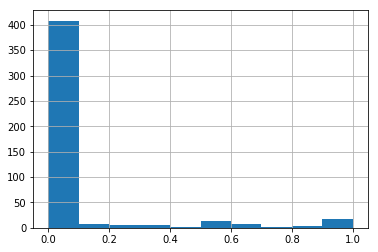

In [30]:
df['false_perc'].hist()

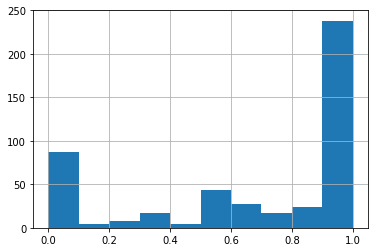

In [31]:
df['true_perc'].hist()

In [32]:
df['known_perc'].quantile(0.9)

0.08695652173913049

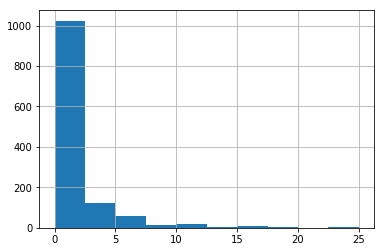

In [33]:
df['known_count'].hist()

In [34]:
df['known_count'].quantile(0.95)

6.0

In [35]:
len(df[df['known_count'] >= 1])

470

In [36]:
len(df[df['known_count'] >= 5])

106

In [37]:
len(df[df['known_count'] >= 10])

35

In [38]:
df.label.value_counts()

false                   700
true                    187
miscaptioned            168
mixture                  64
unproven                 43
mostly false             31
mostly true              23
undetermined             17
outdated                  5
multiple — see below      4
probably false            4
partly true               2
multiple                  1
legend                    1
not any more              1
Name: label, dtype: int64

In [84]:
false_labels = ['false', 'mostly false', 'probably false']
true_labels = ['true', 'mostly true', 'partly true']
mix_labels = ['mixture', 'miscaptioned', 'unproven', 'undetermined', 
              'legend', 'outdated', 'multiple — see below', 'multiple', 'not any more']

In [85]:
df.loc[df.label.isin(false_labels), 'label'] = 'false'
df.loc[df.label.isin(true_labels), 'label'] = 'true'
df.loc[df.label.isin(mix_labels), 'label'] = 'mixture'

In [86]:
df.label.value_counts()

false      735
mixture    304
true       212
Name: label, dtype: int64

In [41]:
df[df['known_count'] >= 10].shape

(35, 15)

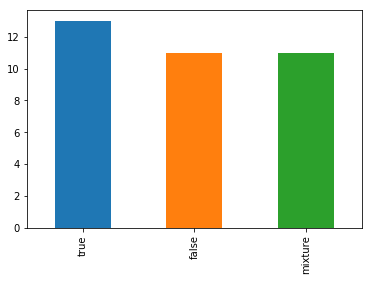

In [42]:
df[df['known_count'] >= 10].label.value_counts().plot.bar()

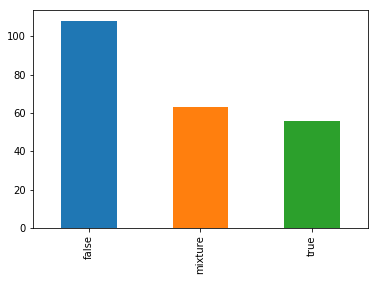

In [43]:
df[df['known_count'] >= 3].label.value_counts().plot.bar()

In [44]:
now = strftime("%Y-%m-%d %H:%M:%S", gmtime())
df[df['known_count'] >= 5].to_csv('../../data/processed/media_ris_5.csv', index=False)
df[df['known_count'] >= 1].to_csv('../../data/processed/media_ris_1.csv', index=False)

In [45]:
df[df['known_count'] >= 3].to_csv('../../data/processed/media_ris_3.csv', index=False)

In [46]:
df[df['known_count'] >= 1].shape

(470, 15)

In [73]:
urlparse('www.stwity.com/Ayedestinaay/')

ParseResult(scheme='', netloc='', path='www.stwity.com/Ayedestinaay/', params='', query='', fragment='')

In [74]:
urlparse('https://stwity.com/Ayedestinaay/').netloc

'stwity.com'

In [70]:
url

'stwity.com'

In [ ]:
return url.strip('/').strip('https:').strip('http:').strip('//www.')

In [72]:
url.replace('https:', '')

'stwity.com'